# El problema a resolver

El principal problema es el siguiente: Dado distintas maquinas del rubro de la fabricación de tubos y perfiles de acero galvanizado, se necesita saber cuando ocurrirá una nuva mantención correctiva en cada una de las maquinas. Para ello, se cuenta con un dataset que contiene la fecha en que se realizó una mantención `Fecha`, el codigo de maquina `cCodigoMaquina` y el tipo de mantención `cDetencion`, si la mantención es correctiva el valor es `S`, si es preventiva el valor es `N`. 

## Lectura del set de datos

Comencemos importando las librerías requeridas para nuestro proyecto así realizando tambien la lectura del set de datos (que se encuentra almacenado en formato XLSX).

En particular importamos el dataset desde la carpeta del proyecto llamada `data`, utilizamos la librería `Pandas` para la lectura del archivo y almacenamos el contenido en un DataFrame llamado `df`.

## Librerías a utilizar

1. **NumPy:** Biblioteca fundamental para cálculos numéricos en Python. Se utiliza para manejar matrices y realizar operaciones matemáticas eficientes.

2. **Pandas:** Biblioteca esencial para la manipulación y análisi de datos. se utiliza para leer, procesar y analizar estructuras de datso como DataFrames.

3. **MinMaxScaler:** Clase de scikit-learn para calcular y mostrar una matriz de confusión, útil para evaluar el rendimiento de un modelo de clasificación.

4. **Confusion Matrix:** Funciones de scikit-learn para calcular y mostrar una matriz de confusión, útil para evaluar el rendimiento de un modelo de clasificación.

5. **TimeseriesGenerator:** Clase de TensorFlow/Keras que genera datos de series temporales para modelos de redes neuronales recurrentes (RNN), como LSTM.

6. **Sequential Model:** Clase de Keras utilizada para crear modelos de redes neuronales secuenciales, donde las capas se añaden una tras otra.

7. **LSTM y Dense Layers:** Clases de Keras para crear capas LSTM y densas. LSTM (Long Short-Term Memory) se utiliza para modelar secuencias de datos, mientras que Dense se utiliza para crear capas completamente conectadas en una red neuronal.

8. **Matplotlib:** Biblioteca de visualización en Python, utilizada para crear gráficos y visualizaciones. En este caso, se utiliza para graficar la precisión, pérdida y resultados del modelo.

In [40]:
import numpy as np
import pandas as pd
import gdown
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# ID del archivo en Google Drive
file_id = '171gRRh-FkAx72nCknXvskG3Egq-K3FzM'

# URL de descarga
url = f'https://drive.google.com/uc?id={file_id}'

# Descargar el archivo
output = '../../data/dataset_v1.xlsx'

gdown.download(url, output, quiet=False)

# Leer el archivo con pandas
df = pd.read_excel(output, skiprows=3)

# Asignar nombres correctos a las columnas
df.columns = ['Fecha_OTM', 'CodigoMaquina', 'Detencion', 'Correctiva', 'Fecha'] # Revisar esto

# Reemplazar 'Fecha_OTM' por 'Fecha' y 'Detencion' por 'Correctiva'
df['Fecha_OTM'] = df['Fecha']
df['Detencion'] = df['Correctiva']

# Eliminar las columnas originales si es necesario
df.drop(columns=['Fecha','Correctiva'], inplace=True)

Downloading...
From: https://drive.google.com/uc?id=171gRRh-FkAx72nCknXvskG3Egq-K3FzM
To: c:\Users\Diego Salazar Dev\Desktop\Practica2\data\dataset_v1.xlsx
100%|██████████| 1.13M/1.13M [00:00<00:00, 7.03MB/s]


## Procesamiento inicial del dataset

In [41]:
# Verificamos el tipo de datos que es la columna 'Fecha'
df['Fecha_OTM'].dtype
df

,Fecha_OTM,CodigoMaquina,Detencion
0,26-12-2022,APE7,0
1,27-12-2022,APE7,0
2,27-12-2022,APE7,0
3,13-01-2023,APE7,0
4,14-01-2023,APE7,0
...,...,...,...
29963,01-02-2024,TB5,0
29964,01-02-2024,TB5,0
29965,01-02-2024,TB5,0
29966,01-02-2024,TB5,0


El resultado nos arroja:

```python
dtype('O')
```

Esto nos indica que el tipo de dato es `object`, por lo que se procede a realizar una conversión de los datos a un formato de tipo `datetime`.

Para convertir esta columna del formato object al formato datetime podemos usar la función `to_datetime` de la librería **Pandas**:

In [42]:
df['Fecha'] = pd.to_datetime(
    df['Fecha_OTM'], 
    format='%d-%m-%Y', 
    errors='coerce')

print(df['Fecha_OTM'].dtype)

#df = df.set_index('Fecha') # me quita el index 0,1,2,3,4, por las fechas, lo cual es erroneo creo, revisar esto
df

object


,Fecha_OTM,CodigoMaquina,Detencion,Fecha
0,26-12-2022,APE7,0,2022-12-26
1,27-12-2022,APE7,0,2022-12-27
2,27-12-2022,APE7,0,2022-12-27
3,13-01-2023,APE7,0,2023-01-13
4,14-01-2023,APE7,0,2023-01-14
...,...,...,...,...
29963,01-02-2024,TB5,0,2024-02-01
29964,01-02-2024,TB5,0,2024-02-01
29965,01-02-2024,TB5,0,2024-02-01
29966,01-02-2024,TB5,0,2024-02-01


Una vez realizada la conversión, podemos fijar esta columna `datetime` como el nuevo índice de nuestro *DataFrame* de **Pandas**, usando la función `set_index`:

In [43]:
df = df.set_index('Fecha')
print(df)

             Fecha_OTM CodigoMaquina  Detencion
Fecha                                          
2022-12-26  26-12-2022          APE7          0
2022-12-27  27-12-2022          APE7          0
2022-12-27  27-12-2022          APE7          0
2023-01-13  13-01-2023          APE7          0
2023-01-14  14-01-2023          APE7          0
...                ...           ...        ...
2024-02-01  01-02-2024           TB5          0
2024-02-01  01-02-2024           TB5          0
2024-02-01  01-02-2024           TB5          0
2024-02-01  01-02-2024           TB5          0
2024-02-01  01-02-2024           TB5          0

[29968 rows x 3 columns]


Adicionalmente debemos garantizar que la variable tiempo de nustra seria (precisamente el índice `Fecha`) está organizada cronológicamente de manera ascendente. Para esto podemos usar la función `sort_index` de **Pandas**:

In [48]:
df.sort_index(inplace=True)
df.drop(columns=['Fecha_OTM'], inplace=True)
df

,CodigoMaquina,Detencion
Fecha,,
2020-01-02,TB4,0
2020-01-02,PG3,0
2020-01-02,TB4,0
2020-01-02,TB4,0
2020-01-02,CR2,0
...,...,...
2024-02-01,PG3,0
2024-02-01,PG1,0
2024-02-01,PE7,0


En este punto ya tenemos un set de datos en donde el índice está en el formato deseado (`datetime`) y donde además las marcas de tiempo tienen un orden cronológico ascendente.

## Análisis exploratorio

El dataset se compone de 3 variables:

- **Fecha:** Marca de tiempo en la que se realizó la mantención.

- **cCodigoMaquina:** Código de la máquina que se mantuvo.

- **cDetencion:** Tipo de mantención realizada (correctiva o preventiva) -> Correctiva = 1, Preventiva = 0.

Además, al momento de implementar el modelo predictivo tendremos tres tipos de variables:

1. La variable a predecir: Que es simplemente la variable que queremos pronosticar y que será la salida del modelo LSTM. En este caso esta variable a predecir es si es que la maquina tuvo preventiva (0) o correctiva (1) (`cDetencion`).

2. Las variables predictoras (o covariables): Que son las variables de entrada del modelo LSTM y a partir de las cuales el modelo podra realizar la predicción. En este caso las covariables son todas las columnas de nustro dataset (incluyendo la misma variable a predecir), por lo que serán `cDentencion` que indica el tipo de mantenimiento, `Fecha` que inda la fecha en que se realizo la mantención y finalmente `cCodigoMaquina` que indica el codigo de maquina al que se le realizo mantenimiento en una fecha determinada.

## Visualizar el set de datos

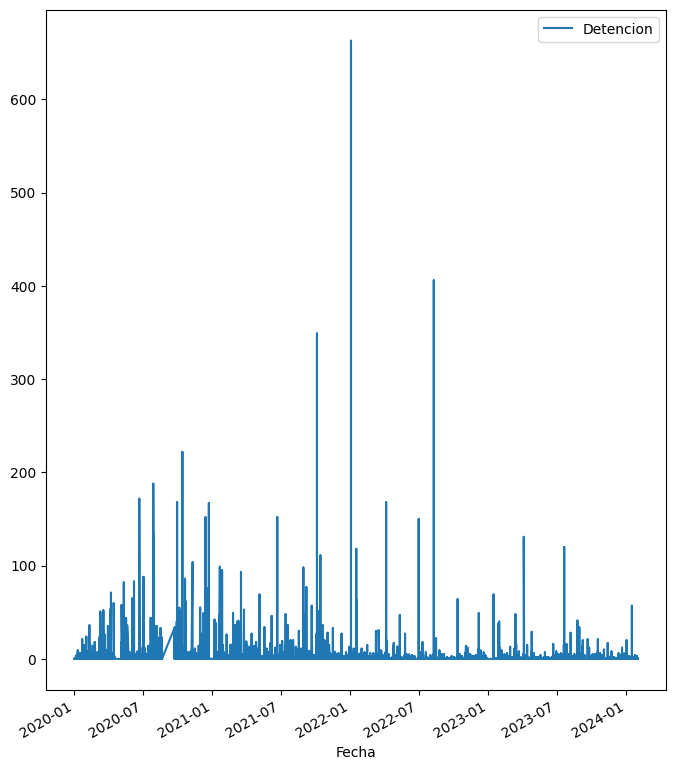

In [49]:
# Columnas del dataset
cols = df.columns

# Dibujar la totalidad de registros
N = df.shape[0] # Numero de registros
plots = df[cols][0:N] # Series de tiempo individuales
plots.index = df.index[0:N] # Variable de tiempo
_ = plots.plot(subplots = True, figsize = (8,10))

## Análisis de datos faltantes

In [50]:
print('Cantidad de NANs: ')
for column in df:
    nans = df[column].isna().sum()
    print(f'\tColumna {column}: {nans}')

Cantidad de NANs: 
	Columna CodigoMaquina: 0
	Columna Detencion: 0


Como podemos ver la cantidad de `NAN's` es 0 por lo que no tenemos datos faltantes en nuestro dataset.

## Análisis de la periodicidad del dataset

En este paso debemos verificar si entre muestras consecutivas del set de datos existe una diferencia temporal.

In [51]:
df_time_diffs = df.index.to_series().diff()
print(df_time_diffs.value_counts())

Fecha
0 days     28697
1 days      1140
2 days        94
3 days        24
4 days         9
18 days        1
32 days        1
5 days         1
Name: count, dtype: int64


Esto indica que:
- Hay muchos mantenimientos que se realizan el mismo día en distintas máquinas. `(0 days -> 28697)`

- Hay un mantenimiento que se realizó en una máquina y al día siguiente se realizó en la misma máquina. `(1 days -> 1140)`

- Hay un mantenimiento que se realizó en una máquina y al día siguiente se realizó en la misma máquina. `(2 days -> 94)`

- Hay un mantenimiento que se realizó en una máquina y a los dos días se realizó la máquina. `(3 days -> 24)`

- Hay un mantenimiento que se realizó en una máquina y a los tres días se realizó la máquina. `(4 days -> 9)`

- Hay un mantenimiento que se realizó en una máquina y a los cuatro días se realizó la máquina. `(5 days -> 4)`

- Hay un mantenimiento que se realizó en una máquina y a los diecisiete días se realizó la máquina. `(18 days -> 1)`

- Hay un mantenimiento que se realizó en una máquina y a los treinta y dos días se realizó en la misma máquina. `(32 days -> 1)`

Por lo que no hay periodicidad en el dataset. En la **versión dos** de esta implemetanción se utilizará una tecnica para darle periodicidad a los datos.

Lo único que nos falta antes de finalizar esta fase de preparación de los datos es almacenar nuestro dataset en formato `CSV`:

In [52]:
# Descargar el archivo
output = '../../data/dataset_v1_preprocessing.csv'
df.to_csv(output)